### Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import re
import itertools
import nltk
import tensorflow as tf

nltk.download('stopwords') # for stopwords
nltk.download('punkt')    # for tokenizing
nltk.download('wordnet')  # for lemmatizing
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import regularizers

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import EarlyStopping
tf.config.run_functions_eagerly(True)

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Reading JSON file

In [2]:
data = []
with open('News Dataset.json', mode='r', errors='ignore') as json_file:
    for dict in json_file:
        data.append( json.loads(dict) )

In [3]:
print("No of news articles: ", len(data))
print("Random data: " , data[50])

No of news articles:  200853
Random data:  {'category': 'ENTERTAINMENT', 'headline': "James Corden And Adam Levine Get Pulled Over During 'Carpool Karaoke'", 'authors': 'Ed Mazza', 'link': 'https://www.huffingtonpost.com/entry/james-corden-adam-levine-carpool-karaoke-pulled-over_us_5b07b025e4b0fdb2aa5206b9', 'short_description': 'It was bound to happen.', 'date': '2018-05-25'}


#### Only category, headline and short description is relevant. Hence, we use only these 3 columns

In [4]:
df = pd.DataFrame(data)
df = df[['category', 'headline', 'short_description']]
df

,category,headline,short_description
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,She left her husband. He killed their children...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Of course it has a song.
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,The actor and his longtime girlfriend Anna Ebe...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,The actor gives Dems an ass-kicking for not fi...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,"The ""Dietland"" actress said using the bags is ..."
...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,Verizon Wireless and AT&T are already promotin...
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,"Afterward, Azarenka, more effusive with the pr..."
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...","Leading up to Super Bowl XLVI, the most talked..."
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,CORRECTION: An earlier version of this story i...


<AxesSubplot:>

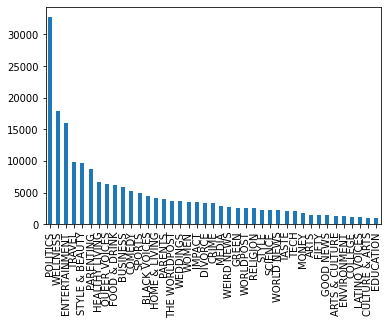

In [5]:
df['category'].value_counts().plot(kind='bar')

#### There are 30 categories and since the count is skewed we take only 5 categories and 4000 values from each category

In [6]:
#  politics, entertainment, sports, business, food & drink
df = df[df['category'].isin(['POLITICS', 'ENTERTAINMENT', 'SPORTS', 'BUSINESS', 'FOOD & DRINK'])]
df.shape

(65844, 3)

In [7]:
df_politics = df[df['category'].isin(['POLITICS'])].sample(n=4000)
df_entertainment = df[df['category'].isin(['ENTERTAINMENT'])].sample(n=4000)
df_sports = df[df['category'].isin(['SPORTS'])].sample(n=4000)
df_business = df[df['category'].isin(['BUSINESS'])].sample(n=4000)
df_foodanddrink = df[df['category'].isin(['FOOD & DRINK'])].sample(n=4000)

In [8]:
print(df_politics.shape, df_entertainment.shape, df_sports.shape, df_business.shape, df_foodanddrink.shape)

(4000, 3) (4000, 3) (4000, 3) (4000, 3) (4000, 3)


In [9]:
new_df = df_politics 
new_df = new_df.append(df_entertainment, ignore_index = True)
new_df = new_df.append(df_sports, ignore_index = True)
new_df = new_df.append(df_business, ignore_index = True)
new_df = new_df.append(df_foodanddrink, ignore_index = True)
# + df_entertainment + df_sports + df_business + df_foodanddrink

In [10]:
new_df["headline and short_description combined"] = new_df["headline"] + new_df["short_description"]

In [11]:
print('Shape of redefined data: ', new_df.shape)
new_df

Shape of redefined data:  (20000, 4)


,category,headline,short_description,headline and short_description combined
0,POLITICS,"A Call To ""Winter Soldiers of Conscience""!",,"A Call To ""Winter Soldiers of Conscience""!"
1,POLITICS,63 Percent Of Americans Believe Donald Trump T...,"And 40 percent believe he did something ""illeg...",63 Percent Of Americans Believe Donald Trump T...
2,POLITICS,Fake Vigils Honor Victims Of Kellyanne Conway'...,"""Never remember, always forget!""",Fake Vigils Honor Victims Of Kellyanne Conway'...
3,POLITICS,The Real Attack on the Spirit of Christmas,"The principle that one should ""love they neigh...",The Real Attack on the Spirit of ChristmasThe ...
4,POLITICS,Sen. Mark Warner Warns Trump: Firing Robert Mu...,Sen. Mark Warner also slammed Republicans and ...,Sen. Mark Warner Warns Trump: Firing Robert Mu...
...,...,...,...,...
19995,FOOD & DRINK,Bubbles Rising: Sparkling Trend in Santa Barbara?,An increasing number of excellent Santa Barbar...,Bubbles Rising: Sparkling Trend in Santa Barba...
19996,FOOD & DRINK,The 8 Secrets to Beating Everyone in Flip Cup,There are two ways to become a superior flip c...,The 8 Secrets to Beating Everyone in Flip CupT...
19997,FOOD & DRINK,Drew Brees Is a __________!,There weren't many middle of the road opinions...,Drew Brees Is a __________!There weren't many ...
19998,FOOD & DRINK,Mighty Spice vs. BarChick -- Round 5,I have teamed up with the awesome BarChick lad...,Mighty Spice vs. BarChick -- Round 5I have tea...


<AxesSubplot:>

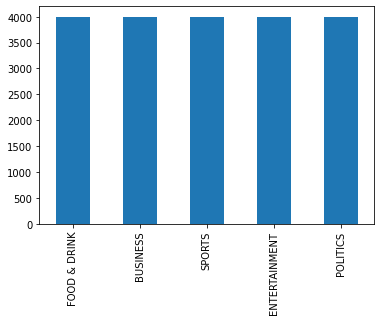

In [12]:
new_df['category'].value_counts().plot(kind='bar')

## Text Pre-processing

### Removing stop words and noise

Convert to lower case. Remove punctuations, tokenize and remove sto words

In [13]:
stop_words = set(stopwords.words('english'))
text = "This project is based on text processing. Hope the accuracy will be good."
text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
word_tokens = word_tokenize(text)
filtered_sentence = []

for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)
        
print("Filtered sentence after removing stop words: " , filtered_sentence)

Filtered sentence after removing stop words:  ['project', 'based', 'text', 'processing', 'hope', 'accuracy', 'good']


### Stemming

Remove suffixes like -ed, -ing, -ly, -tion

In [14]:
ps = PorterStemmer()
stemmed_word = []
for w in filtered_sentence:
    stemmed_word.append(ps.stem(w))
    
print("Stemmed words: " , stemmed_word)

Stemmed words:  ['project', 'base', 'text', 'process', 'hope', 'accuraci', 'good']


### Lemmatization

Eliminate redundant prefix or suffix and get the root word

In [15]:
lemmatizer = WordNetLemmatizer()
lemmatized_word = []
for w in stemmed_word:
    lemmatized_word.append(lemmatizer.lemmatize(w))
    
print("Lemmatized words: ", lemmatized_word)

# Example 
print("Example: ", lemmatizer.lemmatize("playing"))

Lemmatized words:  ['project', 'base', 'text', 'process', 'hope', 'accuraci', 'good']
Example:  playing


### Combining all preprocessing functions

In [16]:
def pre_process(text):
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    word_tokens = word_tokenize(text)
    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
            
    stemmed_word = []
    for w in filtered_sentence:
        stemmed_word.append(ps.stem(w))
    
    lemmatized_word = []
    for w in filtered_sentence:
        lemmatized_word.append(lemmatizer.lemmatize(w))
        
    text = " ".join(lemmatized_word)
    return text
    

In [17]:
new_df["headline_cleaned"] = new_df["headline"].apply(lambda x: pre_process(x))
new_df["short_description_cleaned"] = new_df["short_description"].apply(lambda x: pre_process(x))
new_df["headline_and_short_description_combined_cleaned"] = new_df["headline and short_description combined"].apply(lambda x: pre_process(x))

### Shuffling the data randomly

In [18]:
new_df = new_df.sample(frac=1).reset_index(drop=True)
new_df

,category,headline,short_description,headline and short_description combined,headline_cleaned,short_description_cleaned,headline_and_short_description_combined_cleaned
0,SPORTS,"Ferguson, the Murder of Michael Brown, and the...",Some folks say baseball has nothing to do with...,"Ferguson, the Murder of Michael Brown, and the...",ferguson murder michael brown st louis cardinal,folk say baseball nothing race relation st lou...,ferguson murder michael brown st louis cardina...
1,SPORTS,"Kings Lose to Raptors, Without Cousins Again","The best thing about ""hot"" teams is that they ...","Kings Lose to Raptors, Without Cousins AgainTh...",king lose raptor without cousin,best thing hot team eventually cool unfortunat...,king lose raptor without cousin againthe best ...
2,ENTERTAINMENT,Beyoncé And Jay-Z Enjoy A Kid-Free Evening At ...,"Bey even caught a performance of ""Dear Evan Ha...",Beyoncé And Jay-Z Enjoy A Kid-Free Evening At ...,beyoncé jayz enjoy kidfree evening rihannas di...,bey even caught performance dear evan hansen gala,beyoncé jayz enjoy kidfree evening rihannas di...
3,ENTERTAINMENT,Exclusive: Lawyer Of Woman Who Says Brett Ratn...,“It’s hardly a surprise that they picked one w...,Exclusive: Lawyer Of Woman Who Says Brett Ratn...,exclusive lawyer woman say brett ratner raped ...,hardly surprise picked one woman victimize eff...,exclusive lawyer woman say brett ratner raped ...
4,FOOD & DRINK,Pavlova Recipes: Gorgeous Meringue Desserts We...,Warning: these images will make you extremely ...,Pavlova Recipes: Gorgeous Meringue Desserts We...,pavlova recipe gorgeous meringue dessert cant ...,warning image make extremely hungry,pavlova recipe gorgeous meringue dessert cant ...
...,...,...,...,...,...,...,...
19995,POLITICS,Jeff Sessions Reportedly Revives Probe Of Uran...,An FBI investigation into Hillary Clinton's ti...,Jeff Sessions Reportedly Revives Probe Of Uran...,jeff session reportedly revives probe uranium ...,fbi investigation hillary clinton tie deal fou...,jeff session reportedly revives probe uranium ...
19996,FOOD & DRINK,The Best Cheese Stores in the World: Venissimo...,Did you say cheese? We're not talking Velveeta.,The Best Cheese Stores in the World: Venissimo...,best cheese store world venissimo murray new york,say cheese talking velveeta,best cheese store world venissimo murray new y...
19997,BUSINESS,8 Powerful Habits Of Profoundly Influential Pe...,Influential people have a profound impact on e...,8 Powerful Habits Of Profoundly Influential Pe...,8 powerful habit profoundly influential people,influential people profound impact everyone en...,8 powerful habit profoundly influential people...
19998,ENTERTAINMENT,"John Mollo, 'Star Wars' Costume Designer, Dead...","The Oscar winner, who designed the looks of ""S...","John Mollo, 'Star Wars' Costume Designer, Dead...",john mollo star war costume designer dead 86,oscar winner designed look star war empire str...,john mollo star war costume designer dead 86th...


In [19]:
new_df = new_df.drop(['headline', 'short_description', 'headline and short_description combined'], axis=1)

### Label Encoding
business - 0; entertainment - 1; food and drink - 2; politics - 3; sports - 4

In [20]:
label_encoder = preprocessing.LabelEncoder()
new_df['category'] = label_encoder.fit_transform(new_df['category'])

In [21]:
new_df

,category,headline_cleaned,short_description_cleaned,headline_and_short_description_combined_cleaned
0,4,ferguson murder michael brown st louis cardinal,folk say baseball nothing race relation st lou...,ferguson murder michael brown st louis cardina...
1,4,king lose raptor without cousin,best thing hot team eventually cool unfortunat...,king lose raptor without cousin againthe best ...
2,1,beyoncé jayz enjoy kidfree evening rihannas di...,bey even caught performance dear evan hansen gala,beyoncé jayz enjoy kidfree evening rihannas di...
3,1,exclusive lawyer woman say brett ratner raped ...,hardly surprise picked one woman victimize eff...,exclusive lawyer woman say brett ratner raped ...
4,2,pavlova recipe gorgeous meringue dessert cant ...,warning image make extremely hungry,pavlova recipe gorgeous meringue dessert cant ...
...,...,...,...,...
19995,3,jeff session reportedly revives probe uranium ...,fbi investigation hillary clinton tie deal fou...,jeff session reportedly revives probe uranium ...
19996,2,best cheese store world venissimo murray new york,say cheese talking velveeta,best cheese store world venissimo murray new y...
19997,0,8 powerful habit profoundly influential people,influential people profound impact everyone en...,8 powerful habit profoundly influential people...
19998,1,john mollo star war costume designer dead 86,oscar winner designed look star war empire str...,john mollo star war costume designer dead 86th...


## Train and test split

In [22]:
Y = new_df['category']
new_df = new_df.drop(['category'], axis=1)
X = new_df

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 100)

In [24]:
X_train

,headline_cleaned,short_description_cleaned,headline_and_short_description_combined_cleaned
3906,herrick turkish practice group strike note foo...,first authorization statute expired 2003 since...,herrick turkish practice group strike note foo...
18164,chevron avoid paying cleanup cost hiding behin...,everybody know bury bad news story putting lat...,chevron avoid paying cleanup cost hiding behin...
3829,virginia became first state regulate draftking...,new rule provide least oversight scandalplague...,virginia became first state regulate draftking...
14589,super bowl xlviii halftime show include perfor...,bruno mar confirmed major rumor sunday afterno...,super bowl xlviii halftime show include perfor...
391,elizabeth warren cant stop wont stop laying do...,every day there another piece evidence expose ...,elizabeth warren cant stop wont stop laying do...
...,...,...,...
16304,longmire ready netflix revival exclusive seaso...,new episode premiere sept 10,longmire ready netflix revival exclusive seaso...
79,mcdonalds give menu fancy makeover photo,mcdonalds like youve never seen,mcdonalds give menu fancy makeover photosmcdon...
12119,let forget donald trump would total disaster c...,would say total expensive hoax,let forget donald trump would total disaster c...
14147,pizza pancake plain chicken breakfast dinner r...,request future iteration cheese,pizza pancake plain chicken breakfast dinner r...


In [25]:
y_train = y_train.to_frame()
y_test = y_test.to_frame()

## Tf-Idf  

In [26]:
docs = ["the house had a tiny little mouse", 
"the cat saw the mouse", 
"the mouse ran away from the house", 
"the cat finally ate the mouse", 
"the end of the mouse story"
]

In [27]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
fitted_vectorizer = tfidf_vectorizer.fit(docs)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(docs)

In [28]:
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0] 
first_vector_tfidfvectorizer_score = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
first_vector_tfidfvectorizer_score.sort_values(by=["tfidf"], ascending=False)
first_vector_tfidfvectorizer_score

,tfidf
ate,0.000000
away,0.000000
cat,0.000000
end,0.000000
finally,0.000000
from,0.000000
had,0.493562
house,0.398203
little,0.493562
mouse,0.235185


## Tf-Idf with Logistic Regression

In [29]:
logit = LogisticRegression(C = 5e1, solver='lbfgs', multi_class='multinomial', penalty = 'l2', max_iter = 150)

In [30]:
text_transformer = TfidfVectorizer(ngram_range=(1, 2), max_features = 150000)
X_train_text = text_transformer.fit_transform(X_train['headline_and_short_description_combined_cleaned'])
X_test_text = text_transformer.transform(X_test['headline_and_short_description_combined_cleaned'])

In [31]:
logistic_model_with_tfidf = logit.fit(X_train_text, y_train['category'])
test_score = logistic_model_with_tfidf.score(X_test_text, y_test['category'])
print('Testing accuracy: ', test_score)

Testing accuracy:  0.868


### Stratified K-fold validation

In [32]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
cv_results = cross_val_score(logit, X_train_text, y_train['category'], cv=skf, scoring='f1_micro')
cv_results, cv_results.mean()

(array([0.86694444, 0.86333333, 0.85305556, 0.85861111, 0.86888889]),
 0.8621666666666667)

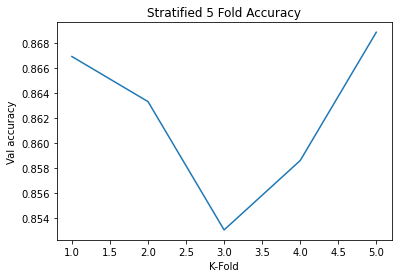

In [33]:
index = [1, 2, 3, 4, 5]
plt.plot(index, cv_results)
plt.title('Stratified 5 Fold Accuracy')
plt.xlabel('K-Fold')
plt.ylabel('Val accuracy')
plt.show()

## Predictions

In [34]:
def get_top_k_predictions(X_test_text, k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = logistic_model_with_tfidf.predict_proba(X_test_text)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_3 = np.argsort(probs, axis=1)[:,-k:]
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[logistic_model_with_tfidf.classes_[predicted_category] for predicted_category in prediction] for prediction in best_3]   
    preds =[ item[::-1] for item in preds]
    
    return preds

In [35]:
predicted_results = get_top_k_predictions(X_test_text, 3)

count = 0
y_predicted = []
y_test_array = y_test['category'].to_numpy()
for i in range(len(y_test_array)):
    if y_test_array[i] == predicted_results[i][0]:
        count += 1
    y_predicted.append(predicted_results[i][0])


In [36]:
print(X_test.iloc[20:21,2:3])
predicted_results[3]

        headline_and_short_description_combined_cleaned
2535  chris brown drake dis singer release dont like...


[4, 1, 0]

## Evaluation Metrics

### Confusion Matrix

Text(0.5, 0, 'Predicted label')

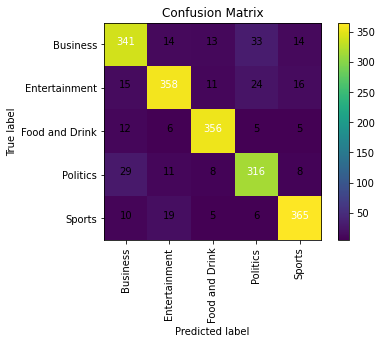

In [37]:
confusion_mtx = confusion_matrix(y_test_array, y_predicted) 
classes = ['Business', 'Entertainment', 'Food and Drink', 'Politics', 'Sports']
plt.imshow(confusion_mtx, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = confusion_mtx.max() / 2.
for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, confusion_mtx[i, j], horizontalalignment="center", color="white" if confusion_mtx[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')

### Classification Report

In [38]:
report = classification_report(y_test_array, y_predicted, target_names=['0','1', '2', '3', '4'])
print(report)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       415
           1       0.88      0.84      0.86       424
           2       0.91      0.93      0.92       384
           3       0.82      0.85      0.84       372
           4       0.89      0.90      0.90       405

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



## Tf-Idf with CNN

In [39]:
model = Sequential()
model.add(Dense(256, input_dim=15000, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(200, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(160, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(120, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(80, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               3840256   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               51400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 160)               32160     
_________________________________________________________________
dropout_2 (Dropout)          (None, 160)               0

### One hot encoding and validation split

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

In [41]:
y_train_onehot = to_categorical(y_train, num_classes=5)
y_val_onehot = to_categorical(y_val, num_classes=5)
y_test_onehot =  to_categorical(y_test, num_classes = 5)

In [42]:
y_train_onehot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

### Running the model

In [43]:
text_transformer = TfidfVectorizer(ngram_range=(1, 2), max_features = 15000)
X_train_text = text_transformer.fit_transform(X_train['headline_and_short_description_combined_cleaned']).astype('float16')
X_test_text = text_transformer.transform(X_test['headline_and_short_description_combined_cleaned']).astype('float16')
X_val_text = text_transformer.transform(X_val['headline_and_short_description_combined_cleaned']).astype('float16')

In [44]:
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(X_train_text, y_train_onehot, validation_data = (X_val_text, y_val_onehot), batch_size = 80, epochs = 25, verbose=1, callbacks = [early_stopping])

Epoch 1/25
203/203 [==============================] - 24s 116ms/step - loss: 4.2841 - accuracy: 0.2369 - val_loss: 3.6396 - val_accuracy: 0.2089
Epoch 2/25
203/203 [==============================] - 23s 114ms/step - loss: 2.7625 - accuracy: 0.6489 - val_loss: 2.2897 - val_accuracy: 0.6606
Epoch 3/25
203/203 [==============================] - 25s 122ms/step - loss: 1.7067 - accuracy: 0.8556 - val_loss: 1.6652 - val_accuracy: 0.8361
Epoch 4/25
203/203 [==============================] - 26s 127ms/step - loss: 1.4615 - accuracy: 0.8837 - val_loss: 1.6065 - val_accuracy: 0.8272
Epoch 5/25
203/203 [==============================] - 23s 115ms/step - loss: 1.4156 - accuracy: 0.8915 - val_loss: 1.5961 - val_accuracy: 0.8517
Epoch 6/25
203/203 [==============================] - 22s 107ms/step - loss: 1.4287 - accuracy: 0.9002 - val_loss: 1.6525 - val_accuracy: 0.8461
Epoch 7/25
203/203 [==============================] - 21s 105ms/step - loss: 1.4245 - accuracy: 0.9067 - val_loss: 1.6451 - val_ac

## Plotting graphs

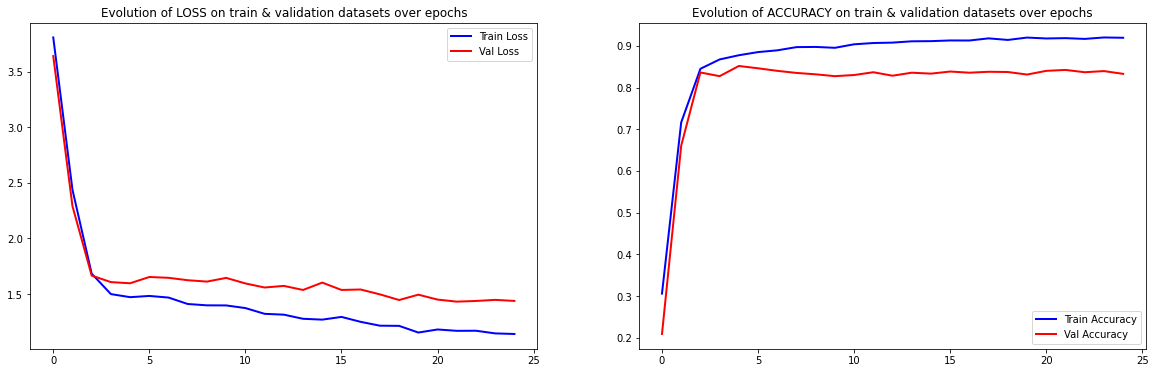

In [45]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_acc = history.history['accuracy']
epoch_val_acc = history.history['val_accuracy']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of LOSS on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_acc)), epoch_acc, 'b-', linewidth=2, label='Train Accuracy')
plt.plot(range(0,len(epoch_val_acc)), epoch_val_acc, 'r-', linewidth=2,label='Val Accuracy')
plt.title('Evolution of ACCURACY on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [46]:
score = model.evaluate(X_test_text, y_test_onehot)
print('Loss of the model: {:.4f}'.format(score[0]))
print('Accuracy of the model: {:.4f}'.format(score[1]))

63/63 [==============================] - 1s 23ms/step - loss: 1.5762 - accuracy: 0.8075
Loss of the model: 1.5762
Accuracy of the model: 0.8075


In [47]:
y_pred = model.predict(X_test_text)
y_pred_label = np.argmax(y_pred,axis = 1) 
y_true_label = np.argmax(y_test_onehot,axis = 1)

## Evaluation metrics

### Confusion matrix

Text(0.5, 0, 'Predicted label')

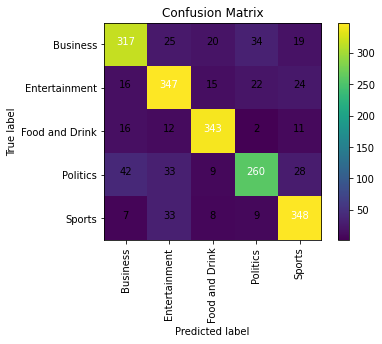

In [48]:
confusion_mtx = confusion_matrix(y_true_label, y_pred_label) 
classes = ['Business', 'Entertainment', 'Food and Drink', 'Politics', 'Sports']
plt.imshow(confusion_mtx, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = confusion_mtx.max() / 2.
for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, confusion_mtx[i, j], horizontalalignment="center", color="white" if confusion_mtx[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')

### Classification report

In [49]:
report = classification_report(y_true_label, y_pred_label, target_names=['0','1', '2', '3', '4'])
print(report)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       415
           1       0.77      0.82      0.79       424
           2       0.87      0.89      0.88       384
           3       0.80      0.70      0.74       372
           4       0.81      0.86      0.83       405

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.81      2000

